In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# What musical trends can be identified among the most popular songs of the most prominent artists?

A computational essay by Kathy Yang and Shruti Venkat

## Introduction

With the abundant choices of songs to listen to today, songs of top artists, the ones that become cultural phenomena, stand out as the most beloved and trendy among most music listeners. These artists are beloved as social idols, often with massive cult followings. Even those unfamiliar with modern trends know these global names.

What musical features of these artists draws people in? Among these artists, what musical attributes contribute to their overwhelming popularity and set them apart from other popular artists? In this computational essay, we study the music features of the top ten most popular songs of the top ten most artists with the most active listeners on Spotify which are The Weeknd, Taylor Swift, Ariana Grande, Rihanna, Drake, Kanye West, Justin Bieber, Dua Lipa, Coldplay, and Bruno Mars. Through data analysis, our objective is to understand each artist’s distinct musical profile in comparison with other popular artists and the musical appeal of these artists to listeners. 

## Methodology

Spotify API was utilized for data collection, which provides numerical values for certain audio features. Due to the volume of features, we decided to focus on four audio features. Here are the four metrics (all values are from 0 to 1) which we decided to closely examine:

Acousticness – A measure of how acoustic a track is. 0 meaning that the song is not acoustic at all, and 1 meaning that the song is entirely acoustic, in which acoustics is a metric of the liklihood of using instruments, as opposed to electronic instruments.

Instrumentalness – A measure representing how much vocals a track has. 0 meaning that the song is entirely vocals, and 1 meaning that the song is entirely instrumentals.

Speechiness – A measure of how many spoken words in a track. 0 meaning that there are no spoken words, and 1 meaning that the song is entirely comprised of spoken words. This is not how fast the song is sung, rather how much of the song is spoken (like a play or podcast) as opposed to sung.

Valence – A measure of how positive or negative a track is. 0 meaning that the track's mood is entirely negative, and 1 meaning that the track is entirely positive.

For set up, our client ID and secret ID are stored in a separate api_keys.py file in which we retrieve credentials to receive an access token from the authorization server. This setup and pull requests to the Spotify API were done with the help of the spotipy library.


### Retrieving the Top Ten Artists and their Top Ten Songs on Spotify 

Below are the necessary modules and libraries for data collection. Spotipy is a library designed for Python interactions with the Spotify API. From spotipy.oath2, the class SpotifyClientCredentials is used for obtaining client credentials authorization flow, which allows us to access the Spotify API. Time is used in sleep() functions, and csv is utilitzed to write our data to CSV files for further use.

In [4]:
from __future__ import print_function
import csv
import time
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

To begin the data collection process, the function get_artist_top_songs() accesses the Spotify API with the help of the library Spotipy, and pulls the top artists and their IDs with their top ten most popular songs. The function searches the name of the artist and retreives an artist_ID, which is used as identification to get their top songs.

In [5]:
def get_artist_top_songs(artist, sp):
    """
    Finds the Spotify ID of the top ten artists by active listeners and
    gathers information of every artists' top ten most popular songs with the
    help of Spotipy library. Collects all data in one list.

    Args:
        artist_name: a string representing the name of the artist to search.
        sp: a function from Spotipy that manages client credential information
            necessary for accessing the API.
    
    Returns:
        A list with general information of the top ten songs of the ten 
        most popular artists.
    """
    tracks_info = []
    all_tracks_info = []

    #search for artist
    results = sp.search(q='artist:' + artist, type='artist')
    if len(results['artists']['items']) == 0:
        print(f"No artist found with the name '{artist}'.")
        return

    #get artist ID
    artist_id = results['artists']['items'][0]['id']

    #get top tracks
    time.sleep(10)
    top_tracks = sp.artist_top_tracks(artist_id)

    #extract information
    for track in top_tracks['tracks']:
        track_info = {
            'artist_name': artist,
            'name': track['name'],
            'track_id': track['id'],
            'popularity': track['popularity'],
            'album_name': track['album']['name'],
            'album_release_date': track['album']['release_date'],
        }
        tracks_info.append(track_info)
    all_tracks_info.extend(tracks_info)

    return all_tracks_info

We decided to get the top tracks of the artists using the artist ID with a sleep function to prevent crossing over Spotify’s API rate limits which can cause an error that could prevent us from retrieving the data. We then extracted a necessary information like the artist's name, name of the track, the ID of the track, the popularity, the album name and the release date of the track. 

### Extracting the average audio features for the tracks 

The get_track_features() function finds the musical features of these songs that we had chosen to analyze in the beginning and returns a dictionary full of audio features of each track from the API. 

In [6]:
def get_track_features(track_id, sp):
    """
    Retrieve audio features for a track from the Spotify API.

    This function utilizes time.sleep() to prevent hitting API rate limits.

    Args:
        track_id: a string representing the unique identifier for the song.
        sp: an authenticated instance of the Spotipy client.

    Returns:
        A dictionary containing audio features of the track obtained from the 
        Spotify API. If the track features are unavailable or if an error 
        occurs, returns None.
    """
    time.sleep(10) # sleep to prevent hitting spotify api rate limits
    features = sp.audio_features(track_id)

    return features[0]

We then moved on to creating a mathematical function called find_average() that takes in a list of numbers or strings and either outputs the mean or mode for both. We decided to implement this because it’s important that we use all the top ten songs from each artist and to do that, we would need to utilize the average feature value of each song.  

In [7]:
def find_average(list):
    """
    Finds the average or mode of a list. 
    
    If the list contains all number (int or float), the function finds mean, 
    and if values are strings, the function uses mode
    
    Args:
        list : a list containing numeric or string values.

    Returns:
        An average if the list's elements are numeric, and a string of the 
        mode if the list's elements are strings.

    """
    if len(list) > 0:
        if isinstance(list[0], (float, int)): # using mean
            return sum(list) / len(list)
        if isinstance(list[0], str): # using mode
            counts = {value:0 for value in list}

            for value in list:
                counts[value] += 1

            max_value = max(counts.values())

            for key, value in counts.items():
                if value == max_value:
                    return key


As we discussed before, the features that we wanted to return were acousticness, instrumentalness, speechiness, and valence along with the artist’s name and the name of their song. 

Our final function to complete extracting the average feature data of each artist is the get_artist_average_features() that takes in the top songs and uses the find_average() function to further return a dictionary of each artist’s average feature data for all four features. 

In [8]:
def get_artist_average_features(top_songs, sp):
    """
    Retrieve and compute the average audio features for an artist's top songs.

    Iterates through the list of top songs for an artist, retrieves their 
    audio features using the Spotify API, and calculates the average of each 
    feature across all songs for each artist.

    This function utilizes time.sleep() to avoid hitting API rate limits.
    
    The function depends on the get_track_features and find_average functions.
    
    Args:
        top_songs: a list of dictionaries containing information about the 
            artist's top songs, including a "track_id".
        sp: an authenticated instance of the Spotipy client.

    Returns:
        A dictionary containing the average audio features for the artist's 
        top songs. The keys are the audio features ("acousticness", 
        "instrumentalness", "speechiness", and "valence"), and the values 
        represent the artist's respective average values of their top songs.
    """
    artist_song_features = {}
    for song in top_songs:
        time.sleep(5)
        song_features = get_track_features(song["track_id"], sp)
        for key, value in song_features.items():
            if key not in features_to_include:
                continue

            existing_values = artist_song_features.get(key)

            if existing_values is None:
                existing_values = []
                artist_song_features[key] = existing_values

            existing_values.append(value)

    average_features = {
        k:find_average(v) for k, v in artist_song_features.items()
    }
    return average_features

### Writing data to CSV file

Write_data_to_csv() takes the dictionary with artist keys and song feature values and writes the data onto a CSV file. Certain information, like "uri" and "track_href" are oitted at this step because they are not applicable for data manipulation afterwards. A CSV file provides a better sense of compatibility with visualization tools and provides for a more readable format to then work with.

In [ ]:
def write_data_to_csv(artists_features, file_name, keys=features_to_include):
    """
    Write artist features to a CSV file.

    This function takes a dictionary of artist features generated from 
    get_artist_average_features(). It writes this data to a CSV file.

    The function excludes certain keys ("type", "id", "uri", "track_href", 
    "analysis_url") from the data that are not applicable for analysis before 
    writing to the CSV file.
    
    Each row in the CSV file represents an artist, and columns corresponds 
    to their feature values.

    Args:
        artists_features: a dictionary where the keys are artist names and the 
            values are dictionaries containing feature information. The nested 
            dictionary contains the feature name as a key, and the data as a 
            value.
            
        file_name: the name of the CSV file to write the data to.

    Returns:
        None.
    """
    exclude = ["type", "id", "uri", "track_href", "analysis_url"]

    data = {
        artist_name: {
            k:v for k, v in features.items() if k not in exclude
        } for artist_name, features in artists_features.items()
    }

    data = [{
        "artist_name": artist_name,
        **features
    } for artist_name, features in data.items()]


    with open(file_name, 'w+', newline='', encoding="utf-8") as file:
        dict_writer = csv.DictWriter(file, keys + ["artist_name"])
        dict_writer.writeheader()
        dict_writer.writerows(data)

Finally, we call the functions which makes the requests, and we write the data into a CSV file. 

In [ ]:
if __name__ == "__main__":
    client_credentials_manager = SpotifyClientCredentials(
                                    client_id=api_keys.CLIENT_ID,
                                    client_secret=api_keys.CLIENT_SECRET)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    artist_names = ['The Weeknd', 'Taylor Swift', 'Ariana Grande', 'Rihanna',
                    'Drake', 'Kanye West', 'Justin Bieber', 'Dua Lipa', 
                    'Coldplay', 'Bruno Mars']

    artists_features = {}
    artists_songs = []

    for artist_name in artist_names:
        top_songs = get_artist_top_songs(artist_name, sp)
        artists_songs.extend(top_songs)
        artists_features[artist_name] = get_artist_average_features(
                                                                top_songs, sp)

    write_data_to_csv(artists_features, "artists_average.csv")
    write_data_to_csv(artists_songs, "artists_songs.csv")

## Results

Below are the used libraries for creating graphs and data manipulations. Matplotlib and seaborn are used to create visualizations. The numpy package helps compute arrays effectively. Adjust_text adds labels onto points of a graph.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text

### Bubble Chart

How can we show four variables on one graph? We decided to create a colored bubble chart, where the x- and y- axis displays two variables-- one each--, color represents the third variable, and size represents the fourth variable. This visualization displays the average value of an artist's songs of each feature.

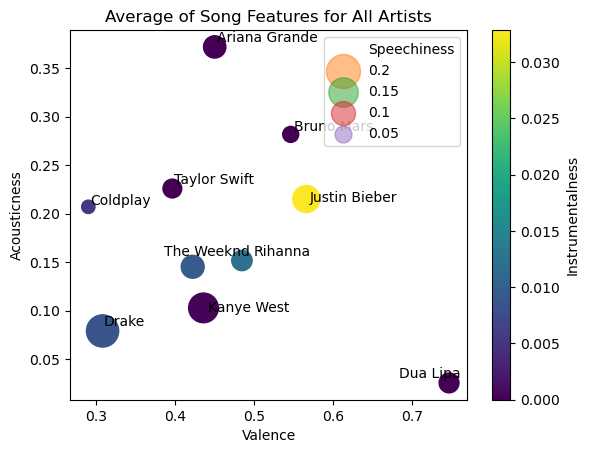

In [ ]:
from plot_charts import average_color_bubble

average_color_bubble()

For valence, most artists have an average that indicates their top songs are mostly negative. Dua Lipa clearly stands out on the valence scale, with a valence of .74, which appears to be the only artist that is positive leaning; most of the other artists hover around .5 or below, meaning they are either neutral or mostly negative. For instrumentalness, all artists have a value that is 0, or close to 0. All of the artists except Ariana Grande appear to cluster for acousticness. Ariana Grande is slightly away from the cluster, and averages higher in acousticness compared to the others. The range of speechiness is relatively small, ranging from .03 to .17. The graph for instrumentalness exists all below 1, so these artists greatly utilize instrumentals.

### Bar Graphs by Feature

To more closely display an artist's musical tendencies, we created a bar graph in which each category is one artist, and the value is the sum of the corresponding feature across their ten songs.

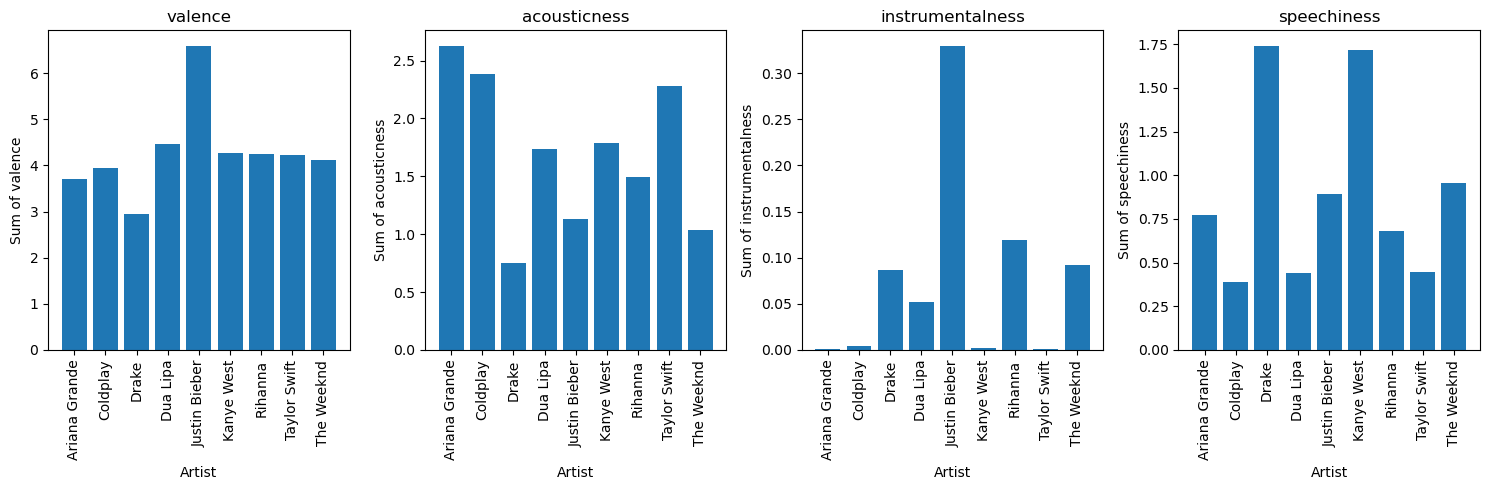

In [12]:
from plot_charts import artist_sums_bar

artist_sums_bar()

The summed bar graph can be used with our knowledge of the artists' average values for features to gain most insights of specific artists. As expected, the level of valence varies the greatest amoung artists, while instrumentalness barely varies. Acousticness and speechiness show relatively higher levels of variability. The graph for instrumentalness exists all below 1, so these artists greatly utilize instrumentals. The speechiness graph shows that there is some range of speechiness among their popular songs. Expectedly, the two with the highest average speechiness value, Drake and Kanye West, have the greatest sums of speechiness by a decent amount compared to the rest of the distribute. The two have values of around 1.7 and 1.6 respectively.


From the bubble chart, we would expect Dua Lipa to have the greatest sum valence value for her songs, but this doesn't seem to be the case! Justin Bieber has a much higher valence sum value at above 6, while Dua Lipa appears to follow the rest of the distribution at around 4.

### Scatterplot Matrix

Are there any patterns within the data? To visualize the relationship between the features, we created a scatterplot matrix.

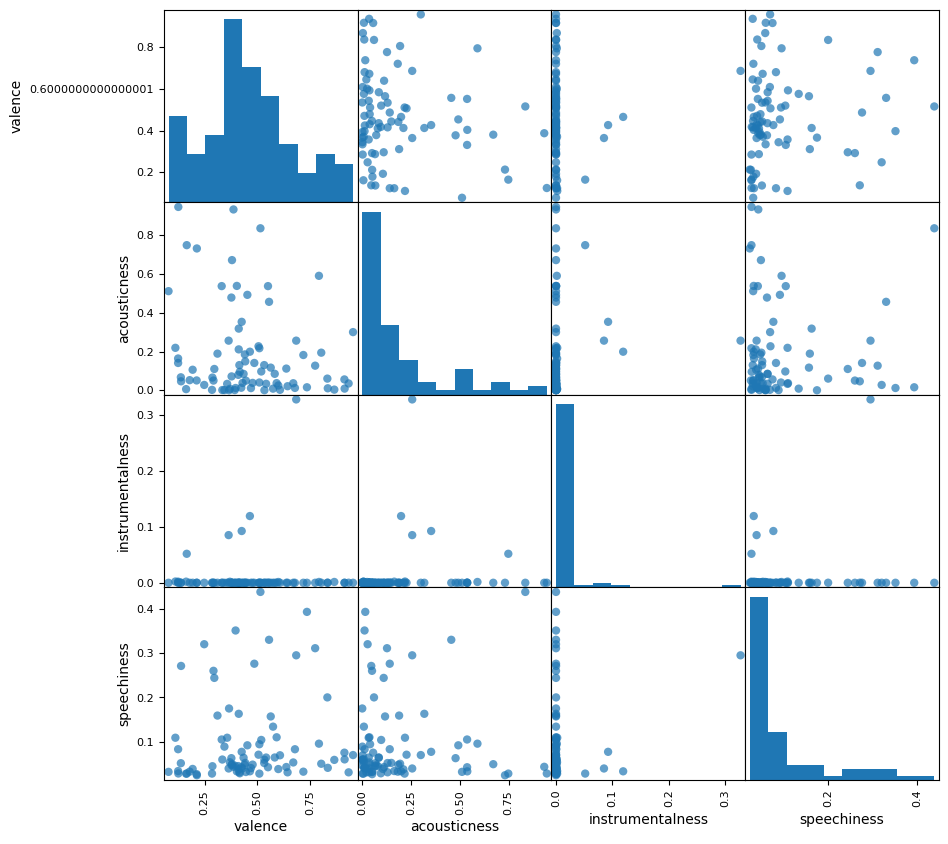

In [ ]:
from plot_charts import track_scatterplot_matrix

track_scatterplot_matrix()

There appears to be no significiant correlations. We created a correlation matrix, which reconfirms the result seen in the scatterplot matrix.

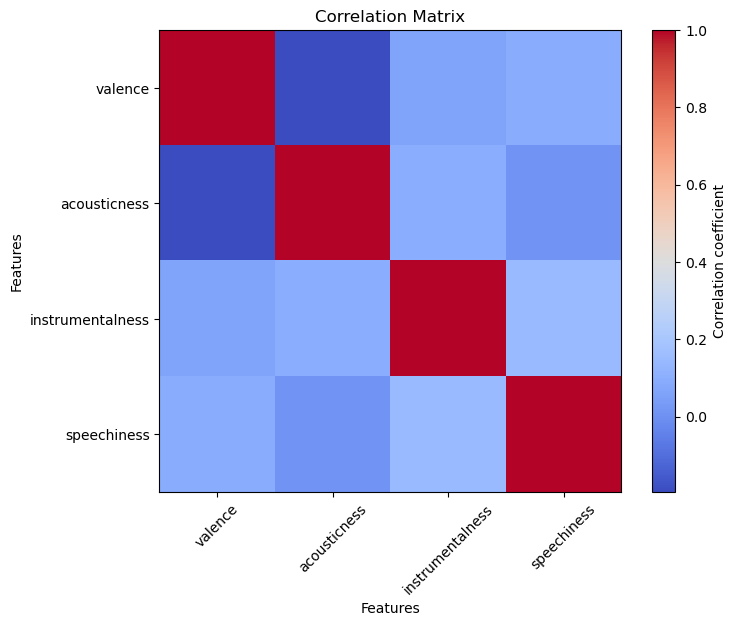

In [ ]:
from plot_charts import correlation_matrix

correlation_matrix()

All correlations were below 0.2 and close to 0, which means there is little to no correlation.


### Box Plots for Features

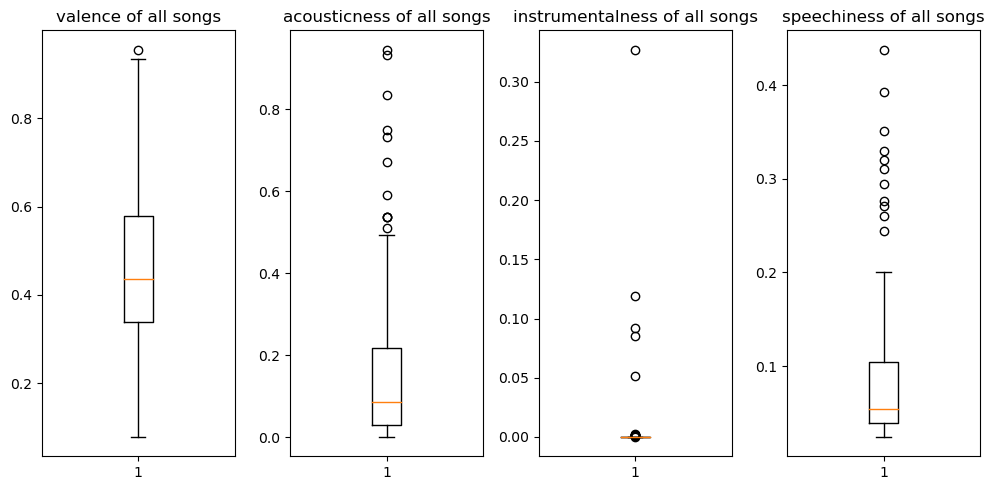

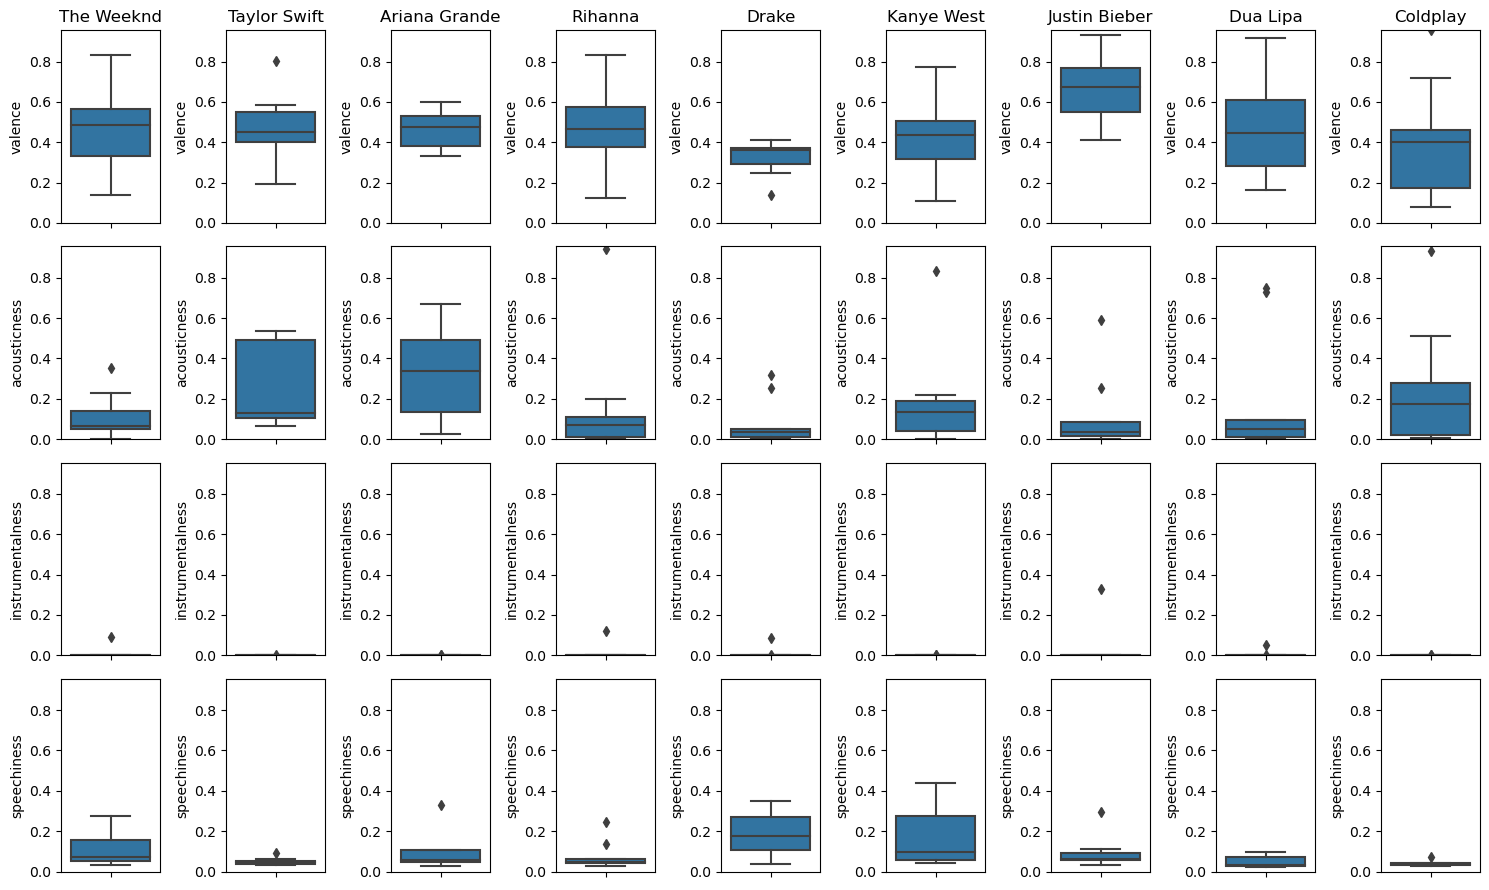

In [11]:
from plot_charts import feature_box_plot, single_artist_box

feature_box_plot()
single_artist_box()

Overall, the boxplots for the artists are just what we would expect, as seen in our previous graphs. Valence tends to be more varied, although leanly more towards smaller values. Acousticness hovers from a range of 0 to .2, and instrumentalness is essentially 0. Speechiness also stays relatively low with a a range of anywhere from 0 to .1-.2.

The valence distributions for Rihanna and The Weeknd look almost symmetrical, which means they have an about equal distribution of happy and sad popular songs. An interesting finding in acousticness (aside from Ariana Grande that has been discussed as averaging amuch higher value) is Taylor Swift's distribution. Although her acousticness average is very low, it has a very long upper tail. Although her average value is low, she has also seen success with songs that utilze more instrumentals. 

## Conclusions

For the most popular songs for the top-listened artists on Spotify, there does appear to be some trends regarding these four track features: valence, acousticness, instrumentalness, and speechiness. For the features acousticness, instrumentalness, and speechiness especially, most artists have similar ranges and distributions. 

The most obvious is instrumentalness, in which all artists have no songs with higher than 0.1 values (aside from outliers). The most popular songs from these artists are comprised mostly of vocals. That means for almost the entirety of all of these songs, the artist's voice can be heard.

As for speechiness, vocalists like the Weeknd, Taylor Swift, Ariana Grande, Rihanna, Justin Bieber, Dua Lipa, and Coldplay, offer songs that are low in speechiness. This is compared to rappers like Drake and Kanye West, who utilize a larger number of spoken words in their song with less emphasis on melody. Even for rappers, speechiness is relatively low on the entire scale; however, I believe this is because values greater than .5 become more interpretted as plays or speeches to the human listening experience, as opposed to music.

Acousticness displays a wide variety of distribution shapes. For the Weeknd, Rihanna, Drake, Justin Bieber, and Dua Lipa, their entire popular song list is contained below .2. This indicates that these artists prefer more electronic styles of sound, as opposed to traditional instruments. Ariana Grande and Coldplay (and to a certain extent, Taylor Swift) see their most popular songs being more acoustic compared to others. Ariana Grande's acousticness distribution is relatively symmetric, when means that her most popular songs can vary greatly in sound, offering a wide range of synthetic and traditional sounds. Taylor Swift has a heavily right skewed acousticness distribution, so about half of her popular songs are low in acousticness (around the same as the first group), while the other half of her popular songs have a large range of higher values in acousticness. A personal guess as to why Taylor Swift's distribution takes a right skew is that some of her most popular songs are from her pop era, while the other half comes from her more modern, softer era. 

Valence of these popular songs seems to vary to most between artist to artist. Regard of the positivity or negativity of a song, these artists can have the song become one of their most popular. Using the sum- which means that we include outliers, Justin Bieber's popular songs is by far the most positive. This comes as a personal shock, as some of my favorite songs from him are angsty. Dua Lipa, on average however, has the most positive popular songs. Coldplay and Drake offer the most negative popular tracks.

There was struggle at every step of the way during this project, but I believe our final product is a testament to our perserverance. Due to API difficulties, we chose to pivot to using the Spotify API, which shortened our timeline. Issues with setting up client credentials with spotipy arose and fights with graphs to work properly were some of the most trifling moments of this project.

If the project alloted more time, I would try pulling these artists' entire discographies, and compare these track features between their most popular songs and their true sound. This further inquiry could provide additional meaningful insights as to what makes a song popular. This could make the distinction to a problem that comes with our current method: are the artists popular because their popular songs have favorable features, or do these songs become the most popular because the artist's discography simply produces this style of sound? By taking this step, we can solve this chicken-and-egg dilemna.

